# Data Preprocessing
Based on key findings from EDA:
- **Target variable imbalance**: 6.53:1 imbalance requires handling
- **Missing values**: 41 columns contain missing values
- **Duplicate Rows**: Only 4,484 unique host IDs in 14,027 rows due to duplicate host IDs between timepoints

## Goals
1. Combine the datasets from 4 individual timepoints
2. Handle Missing Values and Duplicates
3. Train-Validation-Test Split and Cross Validation
4. Address Target Imbalance

In [185]:
# Imports
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [186]:
# Constants
RAW_DATA_DIR = Path("../../data/raw/")
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")

TARGET_COL = "host_is_superhost"
RANDOM_STATE = 42

## Load and Combine Datasets

In [187]:
# Load all 4 timepoints
DATA_FILE_NAMES = [f"airbnb_timepoint{i}.csv" for i in range(1, 5)]
dfs = [pl.read_csv(RAW_DATA_DIR / file_name) for file_name in DATA_FILE_NAMES]

# Combine with diagonal relaxation (handles schema differences)
df = pl.concat(dfs, how="diagonal_relaxed", rechunk=True)

# Drop timepoint-specific columns (identified in EDA)
unique_cols = [
    "estimated_revenue_l365d",
    "availability_eoy",
    "number_of_reviews_ly",
    "estimated_occupancy_l365d",
]
df = df.drop(unique_cols)

print(f"\033[1mCombined dataset:\033[0m {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\033[1mDropped Columns:\033[0m {len(unique_cols)} (timepoint-specific columns)")
df

Combined dataset: 14,027 rows × 75 columns
Dropped Columns: 4 (timepoint-specific columns)


id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
i64,str,i64,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,f64,f64,str,str,i64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,str,str,i64,i64,i64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,i64,i64,f64
275343,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""10min walk to MRT & a Cozy Roo…","""**IMPORTANT NOTES: READ BEFOR…",null,"""https://a0.muscache.com/pictur…",1439258,"""https://www.airbnb.com/users/s…","""Kay""","""2011-11-24""","""Singapore""","""K2 Guesthouse is designed for …","""within an hour""","""100%""","""99%""","""f""","""https://a0.muscache.com/im/pic…","""https://a0.muscache.com/im/pic…","""Bukit Merah""",51,77,"""['email', 'phone']""","""t""","""t""",null,"""Bukit Merah""","""Central Region""",1.28986,103.80948,"""Private room in rental unit""","""Private room""",1,2.0,"""2 shared baths""",1,1,"""[""Bed linens"", ""TV"", ""Dedicate…","""$50.00""",180,999,180,180,1125,1125,180.0,1125.0,null,"""t""",0,0,0,56,"""2024-09-26""",20,0,0,"""2013-04-20""","""2022-08-13""",4.4,4.16,4.26,4.47,4.42,4.53,4.63,"""S0399""","""t""",51,0,51,0,0.14
275344,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""15 mins to Outram MRT Single R…","""Lovely home for the special gu…","""Bus stop <br />Food center <br…","""https://a0.muscache.com/pictur…",1439258,"""https://www.airbnb.com/users/s…","""Kay""","""2011-11-24""","""Singapore""","""K2 Guesthouse is designed for …","""within an hour""","""100%""","""99%""","""f""","""https://a0.muscache.com/im/pic…","""https://a0.muscache.com/im/pic…","""Bukit Merah""",51,77,"""['email', 'phone']""","""t""","""t""","""Singapore, Singapore""","""Bukit Merah""","""Central Region""",1.28883,103.81113,"""Private room in rental unit""","""Private room""",1,2.5,"""2.5 shared baths""",1,1,"""[""Bed linens"", ""TV"", ""Dedicate…","""$50.00""",180,999,180,180,1125,1125,180.0,1125.0,null,"""t""",0,0,0,56,"""2024-09-26""",16,0,0,"""2012-04-26""","""2023-08-16""",4.27,4.44,4.06,4.5,4.5,4.63,4.13,"""S0399""","""t""",51,0,51,0,0.11
294281,"""https://www.airbnb.com/rooms/2…",20240926145704,"""2024-09-26""","""city scrape""","""5 mins walk from Newton subway""","""I have 3 bedrooms in a charmi…",null,"""https://a0.muscache.com/pictur…",1521514,"""https://www.airbnb.com/users/s…","""Elizabeth""","""2011-12-20""","""Singapore""","""Hello ! I am Elizabeth from S…","""N/A""","""N/A""","""N/A""","""f""","""https://a0.muscache.com/im/use…","""https://a0.muscache.com/im/use…","""Central Area""",7,8,"""['email', 'phone']""","""t""","""t""",null,""

## Handle Missing Values and Duplicates
### 1. Drop Rows with null target variables

In [188]:
# Drop rows with null target variables
null_target_count = df[TARGET_COL].null_count()
df = df.drop_nulls([TARGET_COL])

print(f"\033[1mDropped Rows:\033[0m {null_target_count:,} rows with null target")
print(f"\033[1mRemaining:\033[0m {df.shape[0]:,} rows")

Dropped Rows: 146 rows with null target
Remaining: 13,881 rows


### 2. Drop Uninformative Columns based on EDA 

In [189]:
droppable_columns = [
    # 100% Null
    "calendar_updated",
    # Hard to process (URLs, images)
    "host_thumbnail_url",
    "host_picture_url",
    "picture_url",
    "listing_url",
    "host_url",
    # Hard to Interpret
    "license",
    # Redundant (already have calculated versions)
    "host_listings_count",
    "calculated_host_listings_count",
    # Temporal metadata (not features)
    "calendar_last_scraped",
    "scrape_id",
    "source",
]

df = df.drop(droppable_columns)

print(f"\033[1mDropped Columns:\033[0m {len(droppable_columns)} uninformative columns")
print(
    f"\033[1mRemaining DataFrame:\033[0m {df.shape[0]:,} rows × {df.shape[1]} columns"
)

Dropped Columns: 12 uninformative columns
Remaining DataFrame: 13,881 rows × 63 columns


### 3. Handle low null count columns based on EDA

In [190]:
low_null_count_columns = [
    "description",
    "host_name",
    "host_since",
    "host_about",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_total_listings_count",
    "host_has_profile_pic",
    "host_identity_verified",
    "bathrooms_text",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
]

null_row_count = df.filter(
    pl.any_horizontal(pl.col(low_null_count_columns).is_null())
).shape[0]
df = df.filter(pl.all_horizontal(pl.col(low_null_count_columns).is_not_null()))

print(f"\033[1mDropped Rows:\033[0m {null_row_count:,} Rows")
print(f"\033[1mRemaining Rows:\033[0m {df.shape[0]:,} Rows")

Dropped Rows: 460 Rows
Remaining Rows: 13,421 Rows


### 4. Address remaining columns with null data

In [191]:
# Let's check which columns are left to handle first
pl.Config.set_tbl_rows(20)
df.null_count().transpose(include_header=True, column_names=["null_count"]).filter(
    pl.col("null_count") != 0
).sort(by="null_count", descending=True)

column,null_count
str,u32
"""review_scores_location""",6716
"""review_scores_value""",6716
"""review_scores_accuracy""",6715
"""review_scores_cleanliness""",6715
"""review_scores_checkin""",6715
"""review_scores_communication""",6715
"""first_review""",6714
"""last_review""",6714
"""review_scores_rating""",6714


In [192]:
# Handle Text Columns First ("")
text_cols_with_nulls = ["neighborhood_overview", "neighbourhood"]

df = df.with_columns(pl.col(text_cols_with_nulls).fill_null(""))

# Handle Categorical Columns ("Unknown")
categorical_cols_with_nulls = ["host_location", "host_neighbourhood"]

df = df.with_columns(pl.col(categorical_cols_with_nulls).fill_null("Unknown"))

# Handle Numerical Columns ("Mean")
review_cols_with_nulls = [
    "review_scores_location",
    "review_scores_value",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
]

nulls = (
    df.null_count()
    .transpose(include_header=True, column_names=["null_count"])
    .filter(pl.col("null_count") != 0)
    .sort(by="null_count", descending=True)
)
nulls

column,null_count
str,u32
"""review_scores_location""",6716
"""review_scores_value""",6716
"""review_scores_accuracy""",6715
"""review_scores_cleanliness""",6715
"""review_scores_checkin""",6715
"""review_scores_communication""",6715
"""first_review""",6714
"""last_review""",6714
"""review_scores_rating""",6714


In [193]:
# For Reviews, let's try extending reviews to different timepoints and see if that can address the null values
review_columns = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "reviews_per_month",
    "first_review",
    "last_review",
]
df_sorted = df.sort(["id", "last_scraped"])
df = df_sorted.with_columns(
    pl.col(review_columns).fill_null(strategy="forward").over("id")
)


display(df_sorted.select(review_columns).null_count())
display(df.select(review_columns).null_count())

review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review,last_review
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
6714,6715,6715,6715,6715,6716,6716,6714,6714,6714


review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review,last_review
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
6714,6715,6715,6715,6715,6716,6716,6714,6714,6714


In [194]:
# What remains are listings that have never had reviews
# Let's create a has_review column first, then impute these listings with the median review
for col in review_columns:
    df = df.with_columns(
        pl.when(pl.col(col).is_not_null())
        .then(True)
        .otherwise(False)
        .alias(f"has_{col}"),
    )

In [195]:
# First, we need to convert the first_review and last_review into datetime objects
df = df.with_columns(pl.col(["first_review", "last_review"]).cast(pl.Date))

# Then, impute the median and fill in the nulls
for col in review_columns:
    median = df[col].median()
    df = df.with_columns(pl.col(col).fill_null(value=median))

In [196]:
# Let's see what's left again...
nulls = (
    df.null_count()
    .transpose(include_header=True, column_names=["null_count"])
    .filter(pl.col("null_count") != 0)
    .sort(by="null_count", descending=True)
)
display(df.select(nulls["column"].to_list()))

beds,price,bathrooms,bedrooms,has_availability
i64,str,f64,i64,str
null,null,null,2,"""t"""
3,"""$143.00""",1.0,2,"""t"""
2,"""$76.00""",0.5,1,"""t"""
2,"""$76.00""",0.5,1,"""t"""
1,"""$50.00""",2.0,1,"""t"""
1,"""$50.00""",2.0,1,"""t"""
1,"""$50.00""",2.0,1,"""t"""
null,null,null,null,"""t"""
1,"""$50.00""",2.5,1,"""t"""


In [197]:
# Let's try converting the price to a Float64

# First check if all prices are in USD
print(f"\033[1mRemaining df rows:\033[0m {df.shape[0]:,} Rows")
print(
    f"\033[1mNon-USD df rows:\033[0m {df.select(pl.col('price').str.starts_with('$').alias('usd')).filter(pl.col('usd') == False).shape[0]:,} Rows"
)

Remaining df rows: 13,421 Rows
Non-USD df rows: 0 Rows


In [198]:
# Nice, all values are in USD. Converting these strings to floats are trivial in this case
df = df.with_columns(
    pl.col("price")
    .str.strip_prefix("$")
    .str.replace_all(r",", "")
    .cast(pl.Float64)
    .alias("price")
)

In [199]:
# We will fill the null has_availability columns with False, and impute the remainder columns with the median
df = df.with_columns(
    pl.col("has_availability").fill_null(value="f").alias("has_availability"),
)

for column in ["beds", "price", "bathrooms", "bedrooms"]:
    median = df[column].median()
    df = df.with_columns(pl.col(column).fill_null(value=median))

## Type Cleaning
Let's fix the data types as needed (e.g. from String -> Date).

In [200]:
# Check all the columns
print(f"{'\033[1mColumn\033[0m':68} \033[1mDtype\033[0m")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col:60} {dtype}")

Column                                                       Dtype
id                                                           Int64
last_scraped                                                 String
name                                                         String
description                                                  String
neighborhood_overview                                        String
host_id                                                      Int64
host_name                                                    String
host_since                                                   String
host_location                                                String
host_about                                                   String
host_response_time                                           String
host_response_rate                                           String
host_acceptance_rate                                         String
host_is_superhost                                  

In [201]:
temporal_columns = [
    "last_scraped",
    "host_since",
]

boolean_columns = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
    "instant_bookable",
]

for col in temporal_columns:
    df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))

In [202]:
for col in boolean_columns:
    df = df.with_columns(
        pl.when(pl.col(col) == "t").then(True).otherwise(False).alias(col)
    )

In [203]:
# Host Acceptance & Response Rate contains "N/A", i.e. hosts that have never received a booking. We will impute this with the median, since new hosts are likely to behave like average hosts.
df = df.with_columns(
    [
        pl.col("host_acceptance_rate")
        .str.strip_chars("%")
        .replace("N/A", None)
        .cast(pl.Float64)
        .alias("host_acceptance_rate"),
        pl.col("host_acceptance_rate")
        .is_not_null()
        .cast(pl.Boolean)
        .alias("has_acceptance_history"),
        pl.col("host_response_rate")
        .str.strip_chars("%")
        .replace("N/A", None)
        .cast(pl.Float64)
        .alias("host_response_rate"),
        pl.col("host_response_rate")
        .is_not_null()
        .cast(pl.Boolean)
        .alias("has_response_history"),
    ]
)

# Impute with median
median = df["host_acceptance_rate"].median()
df = df.with_columns(pl.col("host_acceptance_rate").fill_null(median))

median = df["host_response_rate"].median()
df = df.with_columns(pl.col("host_response_rate").fill_null(median))

In [204]:
# Let's take a look again
print(f"{'\033[1mColumn\033[0m':68} \033[1mDtype\033[0m")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col:60} {dtype}")

Column                                                       Dtype
id                                                           Int64
last_scraped                                                 Date
name                                                         String
description                                                  String
neighborhood_overview                                        String
host_id                                                      Int64
host_name                                                    String
host_since                                                   Date
host_location                                                String
host_about                                                   String
host_response_time                                           String
host_response_rate                                           Float64
host_acceptance_rate                                         Float64
host_is_superhost                                    

### Duplicates
Duplicate rows are expected due to the combination of 4 timepoints for our dataset.

We will retain these duplicate rows since same listings at different timepoints captures **Temporal Features**: 
- Changes in review scores over time
- Seasonality in pricing and availability
- Host behavior evolution (response rate improvements)

In production, we'd also predict on listings we've seen before (at different times), making this realistic.

In [205]:
unique_listings = df["id"].n_unique()
total_rows = df.shape[0]
duplicate_percentage = ((total_rows - unique_listings) / total_rows) * 100

print(f"\033[1mTotal rows:\033[0m {total_rows:,}")
print(f"\033[1mUnique listings:\033[0m {unique_listings:,}")
print(
    f"\033[1mDuplicate rows:\033[0m {total_rows - unique_listings:,} ({duplicate_percentage:.1f}%)"
)

Total rows: 13,421
Unique listings: 4,359
Duplicate rows: 9,062 (67.5%)


In [206]:
# That said, we should still remove some of these columns which are effectively noise for our model later
remove_cols = [
    "id",
    "host_id",
    "host_name",
    "neighborhood_overview",
]

## Train-Validation-Test Split
Before splitting, we need to stratify the data based on ID to avoid data leakage, and ensure the superhost ratio is similar between all three sets.

We also need to stratify the data as we make our splits, to ensure the superhost ratio is similar between all three sets.

In [220]:
# Separate features (X) and target (y)
X = df.drop("host_is_superhost")
y = df["host_is_superhost", "id"]

print(f"\033[1mTotal dataset shape:\033[0m\nX={X.shape}y={y.shape}\n")

id_target_map = (
    df.sort("last_scraped").group_by("id").agg(pl.col("host_is_superhost").last())
)

unique_ids = df["id"].unique()
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    random_state=42,
    stratify=id_target_map["host_is_superhost"],  # Stratify by ID's target
)

temp_target_map = (
    id_target_map.filter(pl.col("id").is_in(temp_ids)).sort(
        "id"
    )  # Sort by id to maintain consistent order
)

# Create mapping of id to target for lookup
temp_id_list = temp_target_map["id"].to_list()
temp_target_list = temp_target_map["host_is_superhost"].to_list()

val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    random_state=42,
    stratify=temp_target_list,
)

# Verify no ID leakage between sets
train_ids_set = set(train_ids.to_list())
val_ids_set = set(val_ids.to_list())
test_ids_set = set(test_ids.to_list())

assert len(train_ids_set & val_ids_set) == 0, "Train-Val ID overlap!"
assert len(train_ids_set & test_ids_set) == 0, "Train-Test ID overlap!"
assert len(val_ids_set & test_ids_set) == 0, "Val-Test ID overlap!"

X_train = X.filter(pl.col("id").is_in(train_ids)).drop(remove_cols)
X_val = X.filter(pl.col("id").is_in(val_ids)).drop(remove_cols)
X_test = X.filter(pl.col("id").is_in(test_ids)).drop(remove_cols)

y_train = y.filter(pl.col("id").is_in(train_ids)).drop("id")["host_is_superhost"]
y_val = y.filter(pl.col("id").is_in(val_ids)).drop("id")["host_is_superhost"]
y_test = y.filter(pl.col("id").is_in(test_ids)).drop("id")["host_is_superhost"]

print(f"\033[1mTrain set shape:\033[0m\nX={X_train.shape}, y={y_train.shape}\n")
print(f"\033[1mTest set shape:\033[0m\nX={X_test.shape}, y={y_test.shape}\n")
print(f"\033[1mValidation set shape:\033[0m\nX={X_val.shape}, y={y_val.shape}\n")

# Verify stratification
print(f"\033[1mClass distribution:\033[0m")
print(
    f"  Train:      {y_train.sum():,} superhosts ({y_train.sum() / len(y_train) * 100:.2f}%)"
)
print(
    f"  Validation: {y_val.sum():,} superhosts ({y_val.sum() / len(y_val) * 100:.2f}%)"
)
print(
    f"  Test:       {y_test.sum():,} superhosts ({y_test.sum() / len(y_test) * 100:.2f}%)"
)

Total dataset shape:
X=(13421, 74)y=(13421, 2)

Train set shape:
X=(9419, 70), y=(9419,)

Test set shape:
X=(2025, 70), y=(2025,)

Validation set shape:
X=(1977, 70), y=(1977,)

Class distribution:
  Train:      1,327 superhosts (14.09%)
  Validation: 251 superhosts (12.70%)
  Test:       259 superhosts (12.79%)


/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_42702/4168943083.py:20: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  id_target_map.filter(pl.col("id").is_in(temp_ids)).sort(
/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_42702/4168943083.py:45: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  X_train = X.filter(pl.col("id").is_in(train_ids)).drop(remove_cols)
/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_42702/4168943083.py:46: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pol

## Address Target Imbalance
To prevent data leakage, we perform class balancing only on the training set. 

This retains the original distribution for the validation and testing sets, ensuring realistic evaluation.

Our strategy will use SMOTE (oversample minority) + Under-sampling (undersample majority) to balance quality and reduction.

In [221]:
# Strategy: SMOTE (oversample minority) + Under-sampling (undersample majority)
# SMOTE: Minority class = 50% of majority
# Under-sampling: Final ratio = 0.75:1 (minority = 75% of majority)

# Not fully balanced (1:1) to avoid over-correction
# Maintains some imbalance to reflect reality
# Reduces majority class dominance without extreme oversampling

numeric_cols = []
categorical_cols = []
categorical_indices = []  # Positions of categorical columns

for idx, col in enumerate(X_train.columns):
    dtype = X_train[col].dtype
    if dtype in [pl.Float64, pl.Int64, pl.Boolean]:
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)
        categorical_indices.append(idx)

imbalance_pipeline = ImbPipeline(
    [
        (
            "smotenc",
            SMOTENC(
                categorical_features=categorical_indices,
                sampling_strategy=0.5,  # Minority = 50% of majority after this step
                random_state=RANDOM_STATE,
                k_neighbors=5,
            ),
        ),
        (
            "undersampler",
            RandomUnderSampler(
                sampling_strategy=0.75,  # After undersample: minority = 75% of majority
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

print(f"\033[1mApplying balancing pipeline:\033[0m")
print(f"  \033[1mStep 1:\033[0m SMOTE (oversample minority to 50%)")
print(f"  \033[1mStep 2:\033[0m RandomUnderSampler (undersample majority to 0.75:1)")

X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()
X_train_balanced_array, y_train_balanced = imbalance_pipeline.fit_resample(
    X_train_array, y_train_array
)

print(f"\n\033[1mAfter balancing:\033[0m")
print(f"  \033[1mNon-superhosts:\033[0m {(y_train_balanced == 0).sum():,}")
print(f"  \033[1mSuperhosts:\033[0m {(y_train_balanced == 1).sum():,}")
print(
    f"  \033[1mRatio:\033[0m {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1"
)

Applying balancing pipeline:
  Step 1: SMOTE (oversample minority to 50%)
  Step 2: RandomUnderSampler (undersample majority to 0.75:1)

After balancing:
  Non-superhosts: 5,394
  Superhosts: 4,046
  Ratio: 1.33:1


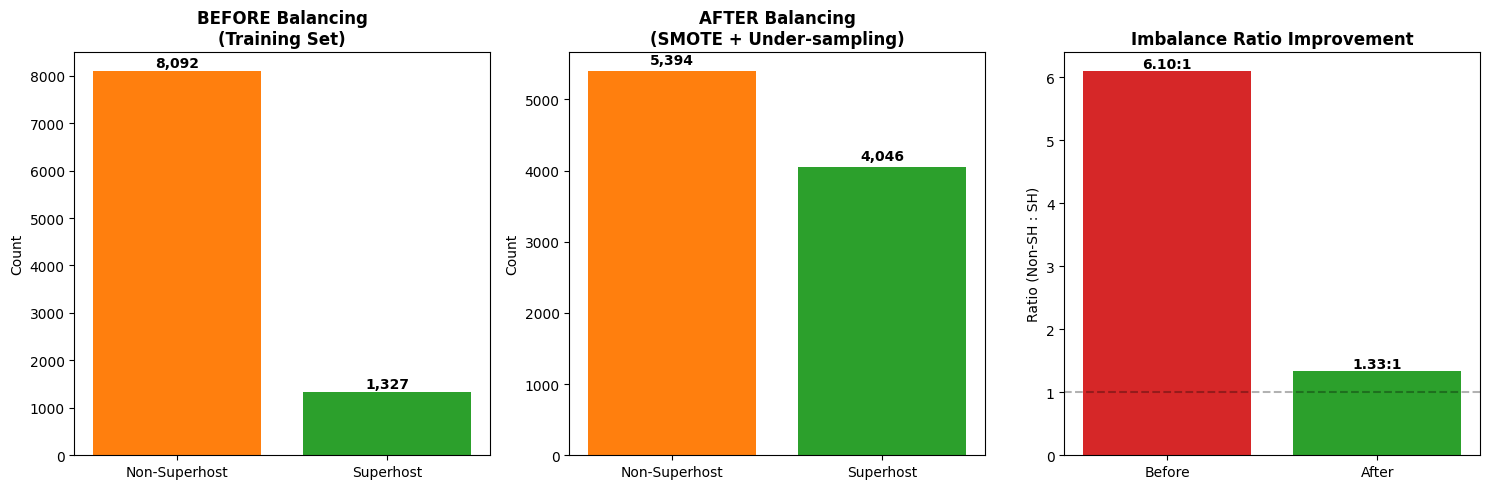

In [222]:
# Visualize Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Before balancing
before_counts = [
    len(y_train_array[y_train_array == 0]),
    len(y_train_array[y_train_array == 1]),
]
axes[0].bar(["Non-Superhost", "Superhost"], before_counts, color=["#ff7f0e", "#2ca02c"])
axes[0].set_title("BEFORE Balancing\n(Training Set)", fontweight="bold")
axes[0].set_ylabel("Count")
for i, v in enumerate(before_counts):
    axes[0].text(i, v + 100, f"{v:,}", ha="center", fontweight="bold")

# After balancing
after_counts = [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()]
axes[1].bar(["Non-Superhost", "Superhost"], after_counts, color=["#ff7f0e", "#2ca02c"])
axes[1].set_title("AFTER Balancing\n(SMOTE + Under-sampling)", fontweight="bold")
axes[1].set_ylabel("Count")
for i, v in enumerate(after_counts):
    axes[1].text(i, v + 100, f"{v:,}", ha="center", fontweight="bold")

# Imbalance ratio comparison
ratios = [before_counts[0] / before_counts[1], after_counts[0] / after_counts[1]]
axes[2].bar(["Before", "After"], ratios, color=["#d62728", "#2ca02c"])
axes[2].set_title("Imbalance Ratio Improvement", fontweight="bold")
axes[2].set_ylabel("Ratio (Non-SH : SH)")
for i, v in enumerate(ratios):
    axes[2].text(i, v + 0.05, f"{v:.2f}:1", ha="center", fontweight="bold")
axes[2].axhline(y=1, color="black", linestyle="--", alpha=0.3, label="Balanced")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "class_balance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [224]:
# Save Results
import pandas as pd

X_train_balanced_df = pl.from_pandas(
    pd.DataFrame(X_train_balanced_array, columns=X_train.columns).convert_dtypes()
)
for col in X_train.schema.keys():
    if X_train.schema[col] == pl.Boolean:
        X_train_balanced_df = X_train_balanced_df.with_columns(
            pl.col(col).cast(pl.Boolean)
        )
y_train_balanced_df = pl.Series(
    "host_is_superhost", y_train_balanced, dtype=pl.UInt8
).to_frame()

X_train_balanced_df.write_parquet(PROCESSED_DATA_DIR / "X_train.parquet")
y_train_balanced_df.write_parquet(PROCESSED_DATA_DIR / "y_train.parquet")

X_val.write_parquet(PROCESSED_DATA_DIR / "X_val.parquet")
y_val.to_frame().write_parquet(PROCESSED_DATA_DIR / "y_val.parquet")

X_test.write_parquet(PROCESSED_DATA_DIR / "X_test.parquet")
y_test.to_frame().write_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

# Save metadata
metadata = {
    "feature_names": X_train.columns,
    "categorical_features": categorical_cols,
    "categorical_indices": categorical_indices,
    "numeric_features": numeric_cols,
    "total_features": len(X_train.columns),
}

with open(PROCESSED_DATA_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("All datasets saved successfully.")

All datasets saved successfully.


## Summary
1. Data from 4 individual was combined into 1 DataFrame (14,027 Rows × 75 Columns)
2. Rows with null target variables were dropped (13,881 Rows; Lost 146 Rows)
3. Columns and Rows were dropped based on EDA to handle missing values (13,421 Rows × 73 Columns)
4. Duplicate Rows were left in to represent temporal variation in the data
5. Columns were coerced into suitable types (e.g. price from String -> Float, first_review from String -> DateTime)
6. Cleaned data was stratified and split into 70% Training, 15% Validation, 15% Testing Sets
7. Training Set underwent a combination of oversampling and undersampling to address class imbalance.

- **Total Rows Removed:** 606
- **Total Columns Dropped:** 12 (Added 10 Imputed Columns)
- **Missing Value Columns Handled:** 41
- **Final Shape:** 13,421 Rows × 73 Columns